***
# 2.1 Categorical rhythm for Bird 22_Internal Consistency Test
### JX, 03/08/2022
***

## Specify Locations

In [1]:
from butcherbird.utils.paths import DATA_DIR

In [2]:
indv = "Bird22"

In [3]:
SAVE_LOC = DATA_DIR/'interim/raw_spectrogram/butcherbird_note_df.pickle'

## Load in Data

In [4]:
import pandas as pd

In [5]:
note_df = pd.read_pickle(SAVE_LOC)

In [6]:
indv_df = note_df[note_df['indv'] == indv].reset_index()

In [7]:
indv_df.head()

,index,phrase_nb,phrase_strt,phrase_end,phrase_len,note_cnt,note_nb,note_strt,note_end,note_len,indv,indvi,key,audio,rate,spectrogram
0,0,0,2.37,4.24,1.87,8,0,2.370000,2.415699,0.045699,Bird22,0,LS110593.9.8.2018Araluen_dn,"[0.0, -5.558967174674641e-06, -5.2225732263302...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,0,2.37,4.24,1.87,8,1,2.660000,2.977558,0.317558,Bird22,0,LS110593.9.8.2018Araluen_dn,"[0.0, 3.069944854750729e-05, 4.037410245845782...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,0,2.37,4.24,1.87,8,2,3.079714,3.173357,0.093643,Bird22,0,LS110593.9.8.2018Araluen_dn,"[0.0, 0.0030796517861769505, 0.008741865222086...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,0,2.37,4.24,1.87,8,3,3.260000,3.581982,0.321982,Bird22,0,LS110593.9.8.2018Araluen_dn,"[-0.0, -0.00020854328852771913, -0.00037995893...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,4,0,2.37,4.24,1.87,8,4,3.664275,3.718191,0.053916,Bird22,0,LS110593.9.8.2018Araluen_dn,"[-0.0, -0.0018707999847079283, -0.003892325714...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Split into recordings

In [8]:
import numpy as np

In [9]:
recs = [indv_df[indv_df['key'] == key] for key in np.unique(indv_df['key'].values)]

In [10]:
len(recs)

2

## Calculate Empirical Rhythm

In [11]:
import butcherbird.rhythm as rhythm
import seaborn as sns

/home/AD/j8xing/syntax_rhythm_pbb/butcherbird/rhythm.py:163: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
dyadics = []

for rec in recs:
    dyadics.append(
        rhythm.construct_rhythm_df(
            rec,
            'indv'
        )
    )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

## Draw Figure

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from butcherbird.utils.paths import FIGURE_DIR
from tqdm.autonotebook import tqdm

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

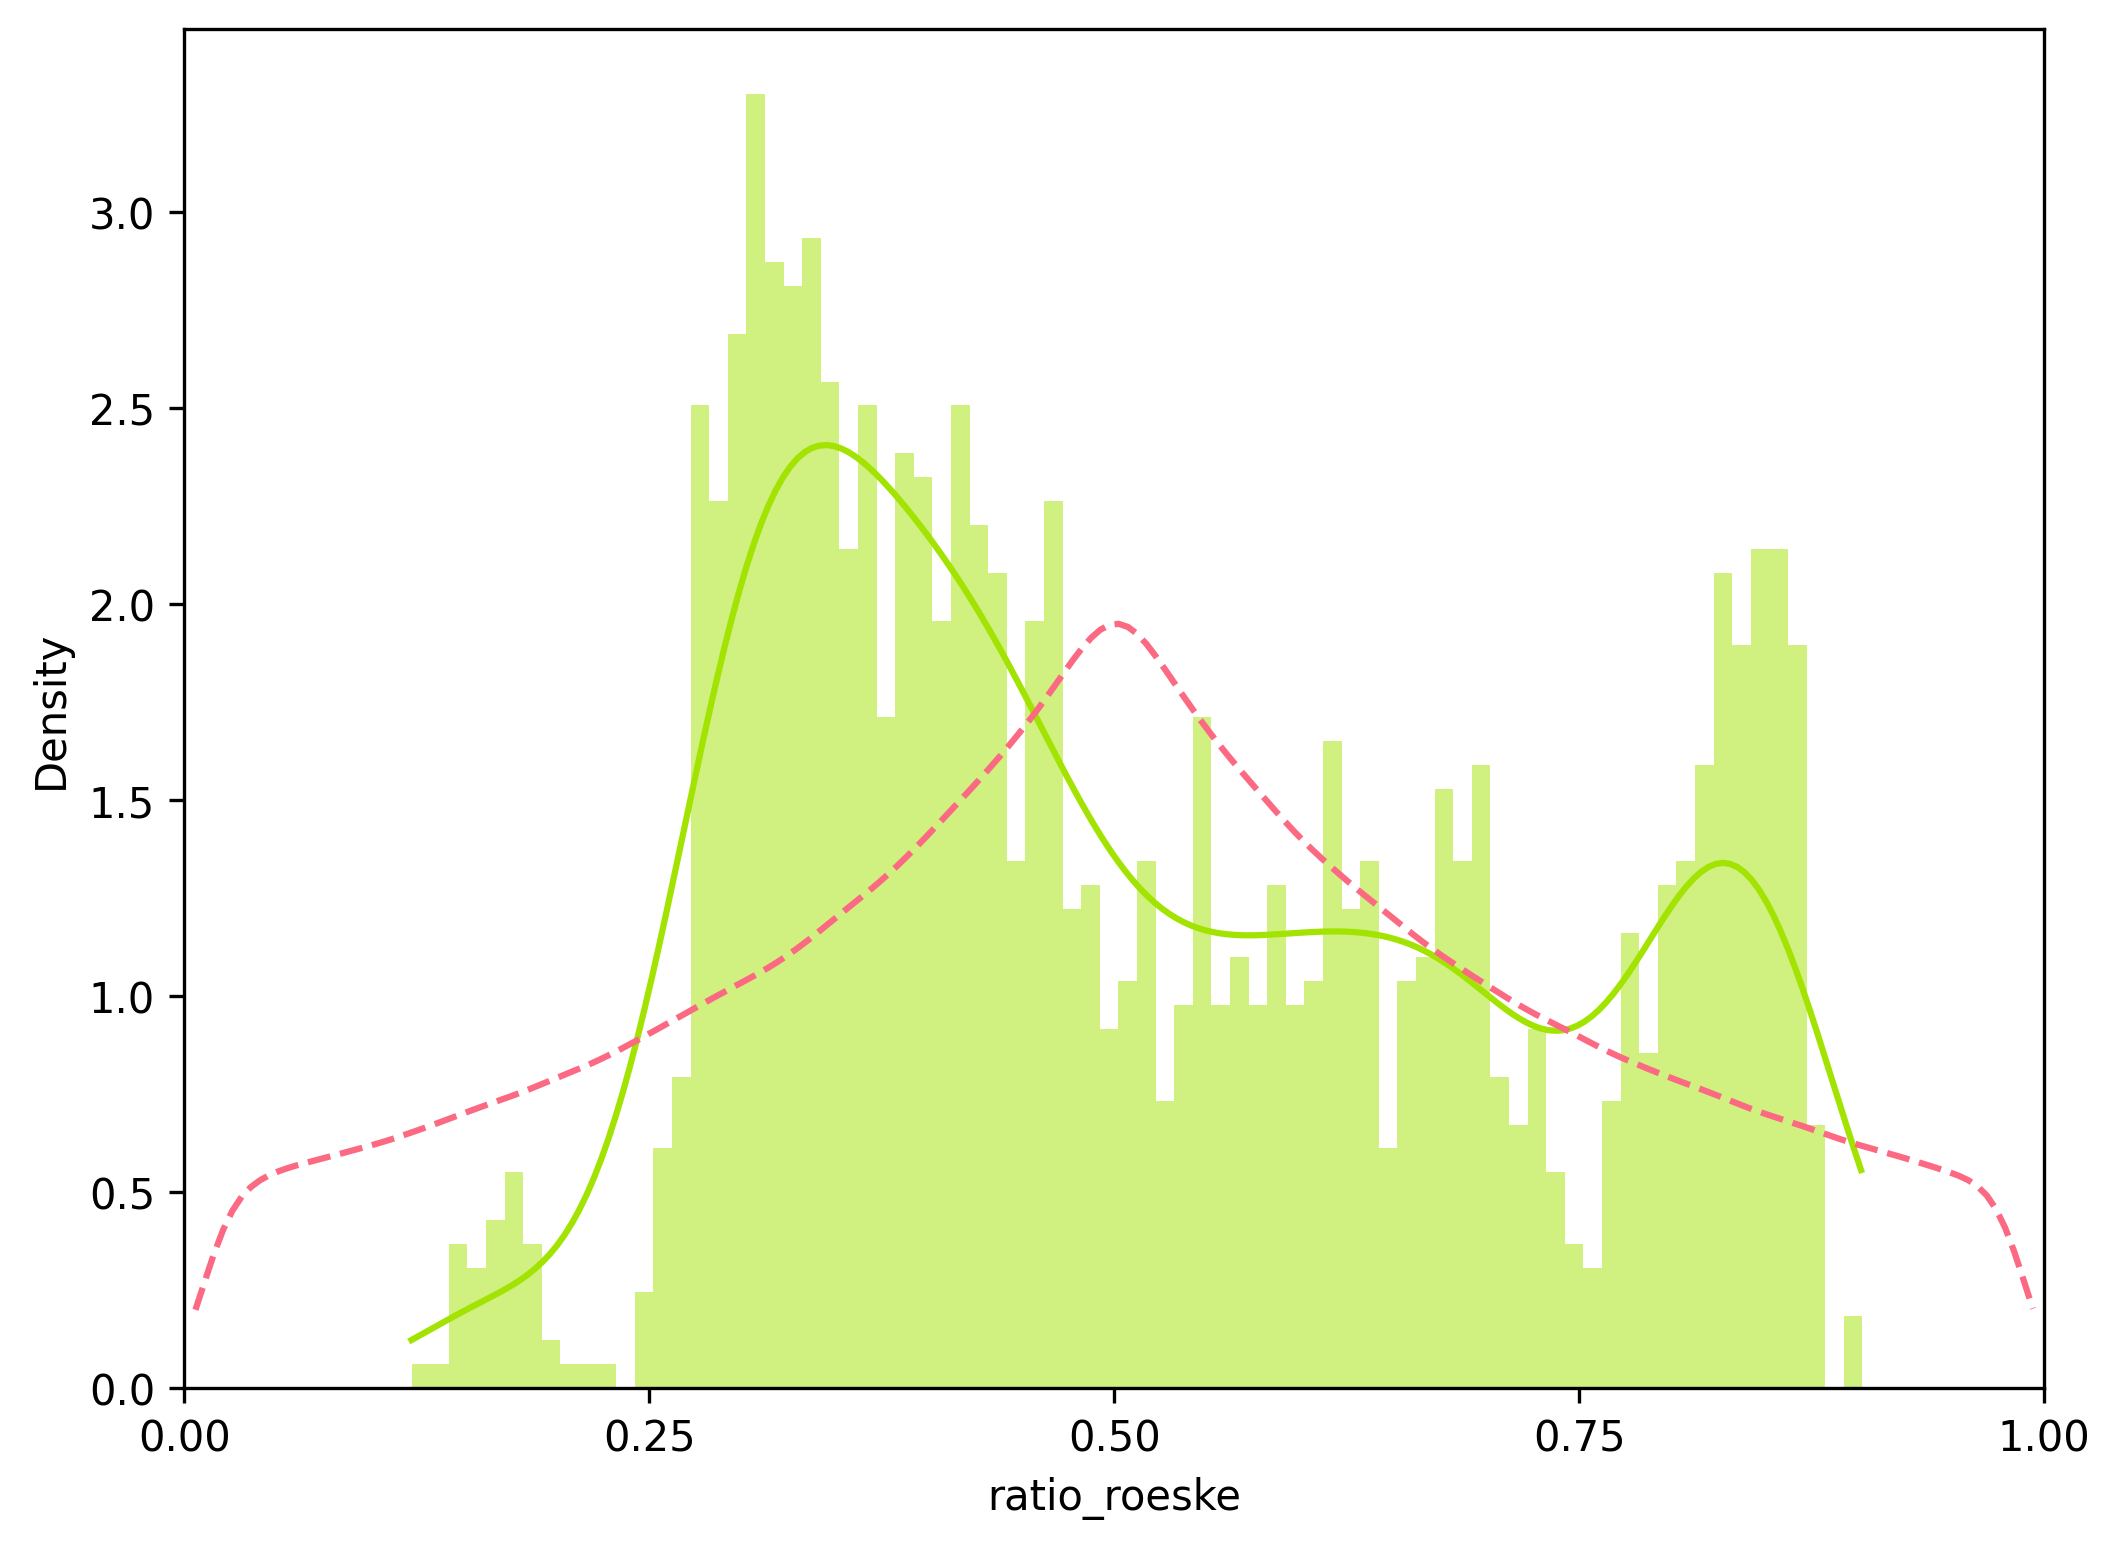

  0%|          | 0/1000 [00:00<?, ?it/s]

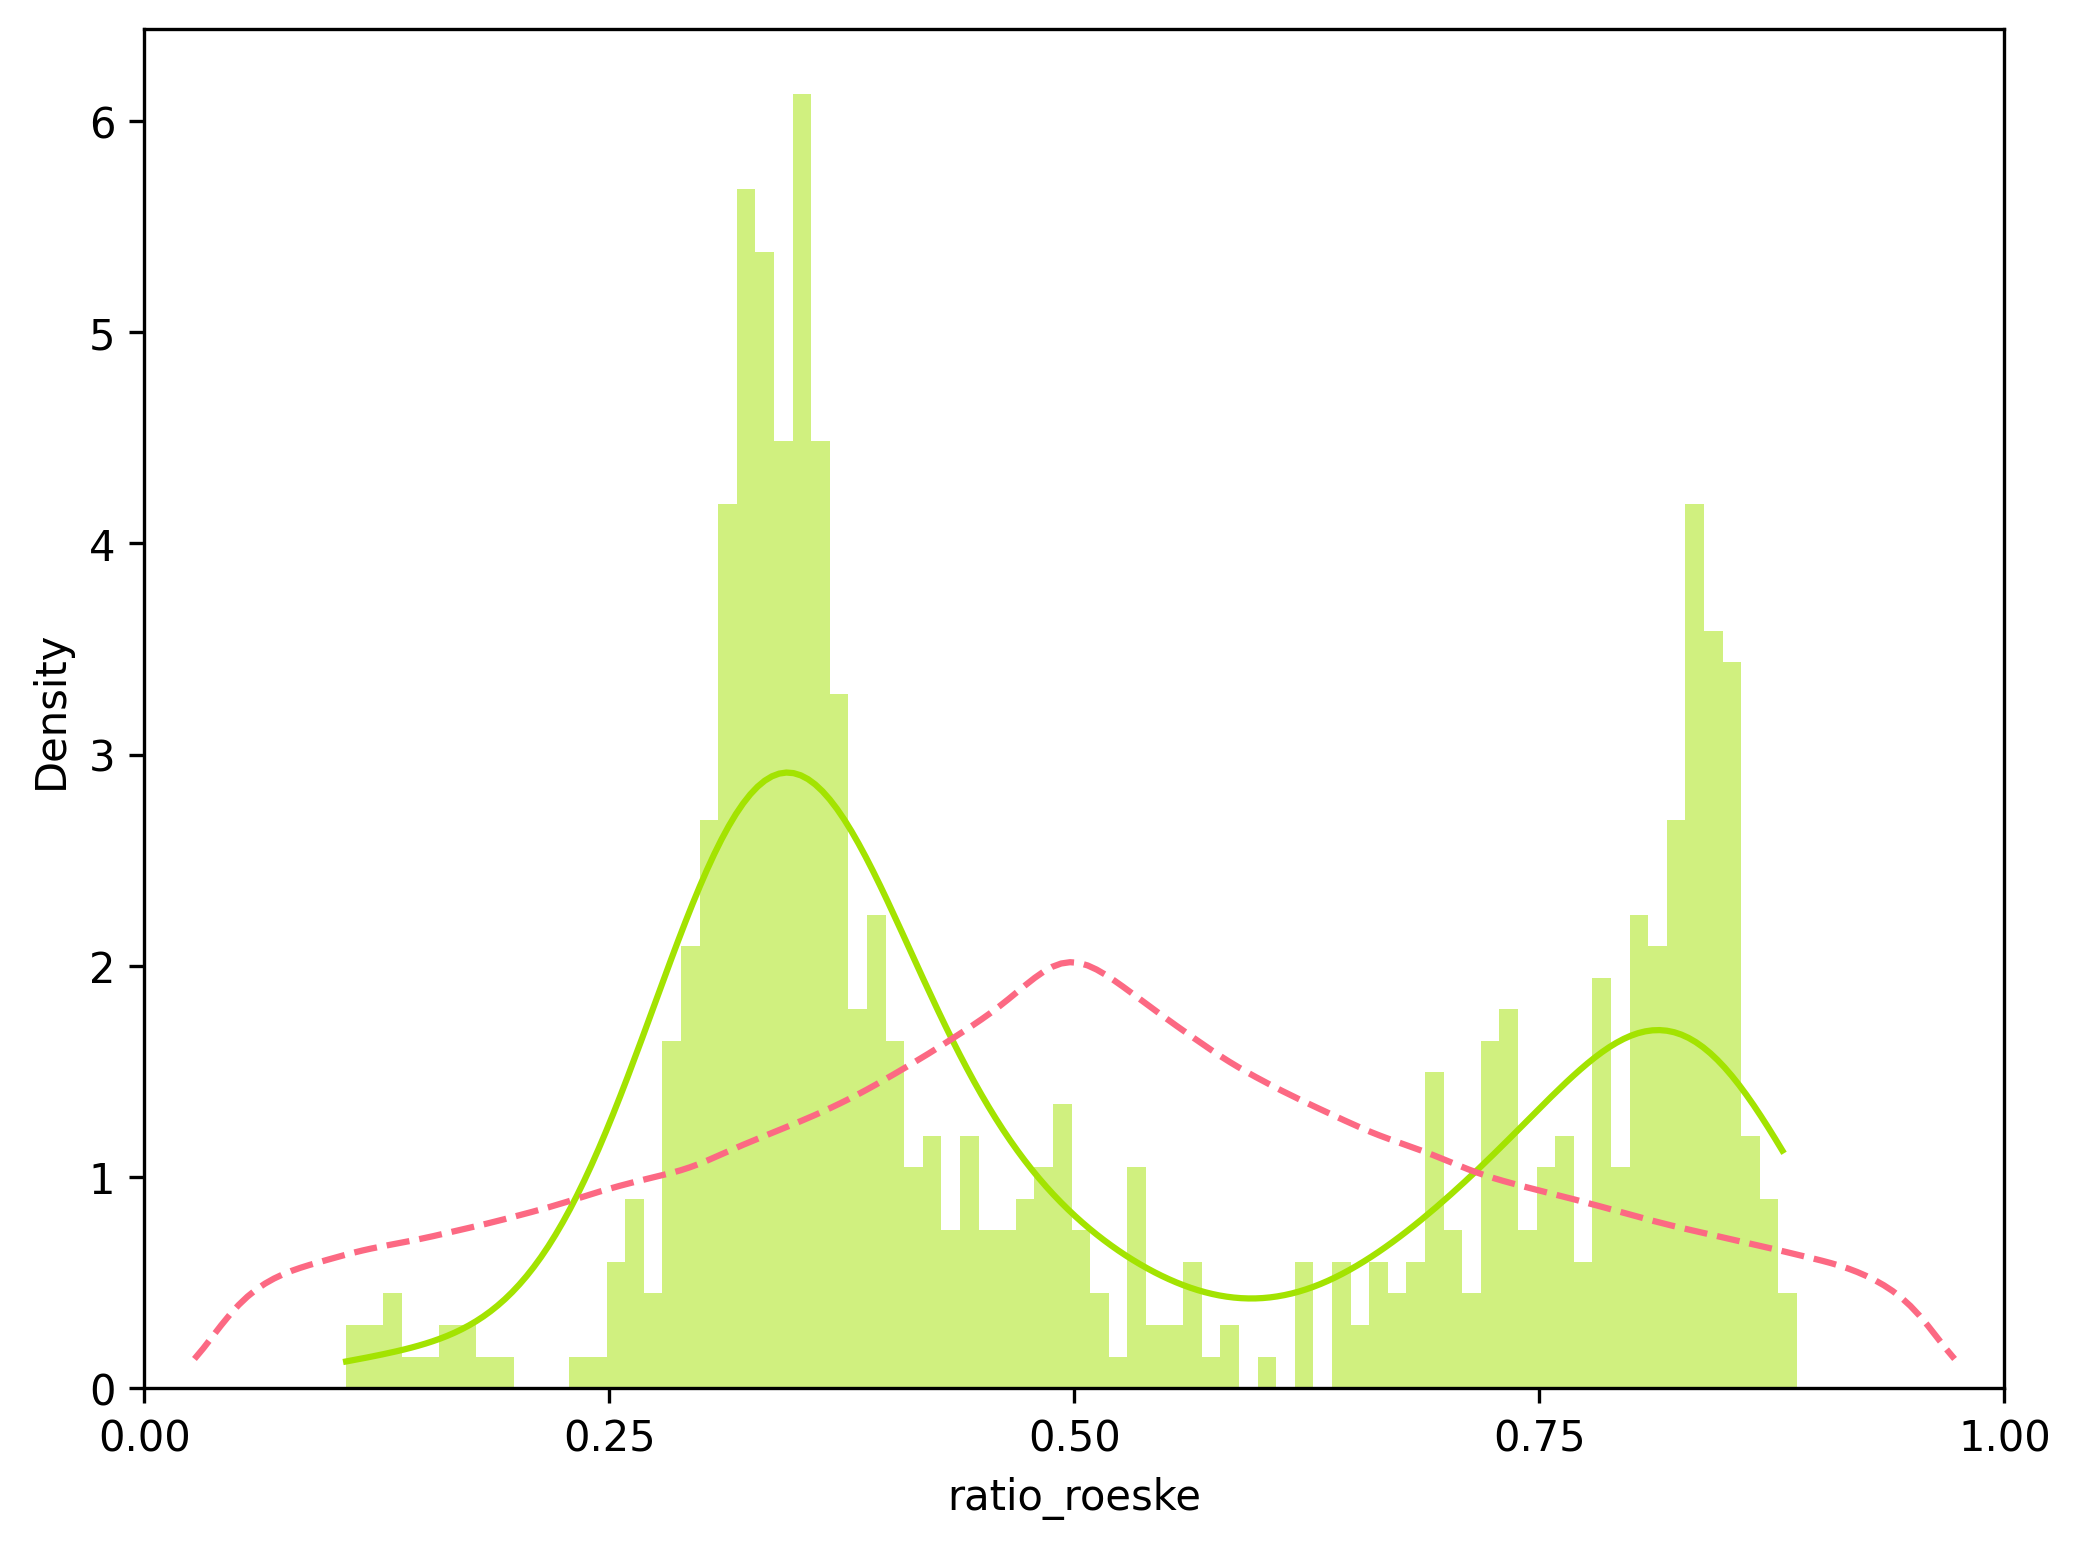

In [14]:
counter = 0
for dyadic in tqdm(dyadics):
    
    figure(figsize = (8, 6), dpi = 300)

    plt.rcParams['patch.edgecolor'] = 'none'

    ## create uniform distribution
    n = 1000
    import numpy as np
    import numpy.random as random
    interval_min = np.min([dyadic['intervals1'].values, dyadic['intervals2']])
    interval_max = np.max([dyadic['intervals1'].values, dyadic['intervals2']])
    df_uni = []
    for i in tqdm(np.arange(0, n)):
        interval1_uni = random.uniform(low = interval_min, high = interval_max, size = len(dyadic))
        interval2_uni = random.uniform(low = interval_min, high = interval_max, size = len(dyadic))
        df_uni.append(interval1_uni / (interval1_uni + interval2_uni))
    uni_ratio = np.array(df_uni).flatten()
    
    fig = sns.histplot(
        x = dyadic['ratio_roeske'],
        binwidth = 0.01,
        stat = 'density',
        color = '#A3E301',
        fill = '#A3E301',
        kde = True,
    )
    
    uni = sns.histplot(
        x = uni_ratio,
        stat = 'density',
        alpha = 0,
        color = '#FC6983',
        kde = True,
        line_kws = dict(linestyle = 'dashed')
    )

    ax = plt.gca()
    ax.set_xlim([0, 1])
    plt.xticks(np.arange(0, 1.25, 0.25))

    # save
    figname = 'fig1_' + 'categorical_rhythm_internal_consistency' + indv + str(counter) + '.pdf'
    plt.savefig(FIGURE_DIR/'categorical_rhythm'/figname)
    plt.show()

In [15]:
from butcherbird.rhythm import hopkins
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

In [16]:
h_iterations = 100
shuffle_iterations = 100
n_jobs = 36

In [17]:
import numpy as np
import scipy.stats

## a standard calculation for confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [18]:
SDoHList = []

## empirical
for dyadic in dyadics:
    SDoH = []

    for i in tqdm(range(0, h_iterations)):
        SDoH.append(hopkins(dyadic[['ratio_roeske']]))

    ## take mean of sampling distribution of Hopkins as best estimate
    SDoHList.append(mean_confidence_interval(SDoH))
    
SDoHList

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[(0.8488172498270875, 0.8421436655683145, 0.8554908340858605),
 (0.8611836057318151, 0.8545582961571438, 0.8678089153064863)]